# 설정

In [6]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Support Vector Machine"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

결정 경계를 그려주는 함수

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, text_idx=None, resolution=0.02):
    
    # 마커와 컬러맵을 설정한다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그린다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
        
    # 테스트 샘플을 부각하여 그린다
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolors='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

다음 코드는 iris 데이터를 불러들이고 학습셋과 테스트셋으로 나눈 후 표준화를 하는 과정이다.

In [3]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 서포트 벡터 머신

<b>서포트 벡터 머신</b><sup>Support Vector Machine, SVM</sup>은 매우 강력하고 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델이다. 머신러닝에서 가장 인기 있는 모델에 속하고 머신러닝에 관심 있는 사람이라면 반드시 알고 있어야 하는 모델이다. SVM은 다음과 같은 특징이 있다.
<ul>
    <li>고차원 데이터의 분류 문제에 잘 들어 맞음</li>
    <li>작거나 중간 크기의 데이터셋에 적합</li>
    <li>train error를 줄이면 test error도 줄어들어 일반화 성능이 좋음</li>
    <li>탄탄한 확률이론에 기반한 모델</li>
    <li><b>마진 최대화</b>를 통해 매끈한 초평면을 학습할 수 있음</li>
    <li><b>커널</b><sup>kernel</sup>이라는 방법을 사용하여 비선형 데이터를 분리할 수 있음</li>
    <li>선형 커널로는 차원 수가 높은 희소<sup>sparse</sup> 데이터도 학습할 수 있음</li>
    <li>배치 학습과 온라인 학습에 모두 적용할 수 있음</li>
</ul>

이 장에서는 SVM의 핵심 개념을 설명하고 사용 방법과 작동 원리를 살펴보겠다.

## 선형 SVM 분류

SVM의 기본 아이디어는 그림으로 설명하는 것이 가장 좋다. [그림 1]에 붓꽃 데이터셋의 일부를 나타냈다. 두 클래스가 직선으로 확실히 잘 나뉘어 있다(<b>선형적으로 구분</b>된다). 왼쪽 그래프에 세 개의 선형 분류기에서 만들어진 결정 경계가 보인다.<sup><a id="a01" href="#p01">[1]</a></sup> 점선으로 나타난 결정 경계를 만든 모델은 클래스를 적절하게 분류하지 못하고 있다. 다른 두 모델은 훈련 세트에 대해 완벽하게 동작한다. 하지만 결정 경계가 샘플에 너무 가까워 새로운 샘플에 대해서는 아마 잘 작동하지 못할 것이다. 오른쪽 그래프에 있는 실선은 SVM 분류기의 결정 경계다. 이 직선은 두 개의 클래스를 나누고 있을 뿐만 아니라 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있다. SVM 분류기를 클래스 사이에 폭이 넓은 도로를 찾는 것으로 생각할 수 있다. 그래서 <b>라지 마진 분류</b><sup>large margin classification</sup>라고 한다.

<b>그림 1</b> 라지 마진 분류
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/large_margin_classification_plot.png">
</div<

도로 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에는 전혀 영향을 미치지 않는다. 도로 경계에 위치한 샘플에 의해 전적으로 결정(또는 의지)된다. 이런 샘플을 <b>서포트 벡터</b><sup>support vector</sup>라고 한다([그림 1]에 동그라미로 표시했다).

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span> SVM은 특성의 스케일에 민감하다. [그림 2]의 왼쪽 그래프에서는 수직축의 스케일이 수평축의 스케일보다 훨씬 커서 가장 넓은 도로가 거의 수평에 가깝게 된다. 특성의 스케일을 조정하면(예를 들어 사이킷런의 StandardScaler를 사용하여) 결정 경계가 훨씬 좋아진다(오른쪽 그래프).</div>

<b>그림 2</b> 특성 스케일에 따른 민감성
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/sensitivity_to_feature_scales_plot.png">
</div>

### 최대 마진

SVM의 최적화 대상은 마진을 최대화하는 것이다. 마진은 클래스를 구분하는 초평면(결정 경계)과 이 초평면에 가장 가까운 훈련 샘플 사이의 거리로 정의한다.

<b>그림 3</b> 서포트 벡터 머신
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/서포트 벡터 머신.png">
</div>

큰 마진(large margin)의 결정 경계를 원하는 이유는 일반화 오차가 낮아지는 경향이 있기 때문이다. 반면에 작은 마진의 모델은 과대적합되기 쉽다. 마진 최대화를 이해하기 위해 결정 경계와 나란히 놓인 양성 샘플 쪽의 초평면과 음성 샘플 쪽의 초평면을 자세히 살펴보겠다. 이 두 초평면은 다음과 같이 쓸 수 있다.<sup><a id="a02" href="#p02">[2]</a></sup>

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/양쪽 초평면 식.png">
</div>

두 선형식 (1)과 (2)를 빼면 다음 결과를 얻는다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/양쪽 초평면 식2.png">
</div>

이 식을 다음과 같은 벡터 w의 길이로 정규화할 수 있다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/w의 길이.png">
</div>

결과 식은 다음과 같다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/초평면 사이의 거리.png">
</div>

이 식의 좌변은 양성 쪽 초평면과 음성 쪽 초평면 사이의 거리로 해석할 수 있다.<sup><a id="a03" href="#p03">[3]</a></sup> 이것이 최대화하려고 하는 <b>마진</b><sup>margin</sup>이다.

SVM의 목적 함수는 샘플이 정확하게 분류된다는 제약 조건하에서 $\frac{2}{||\textbf{w}||}$ 를 최대화함으로써 마진을 최대화하는 것이다. 이 제약은 다음과 같이 쓸 수 있다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/제약.png">
    <i>ⅰ</i>= 1<sup><b>  …</b></sup> <i>N</i> 까지
</div>

여기서 <i>N</i>은 데이터셋에 있는 샘플 개수다.

이 두 식이 말하는 것은 다음과 같다. 모든 음성 샘플은 음성 쪽 초평면 너머에 있어야 하고 양성 샘플은 양성 쪽 초평면 너머에 있어야 한다. 이를 다음과 같이 간단히 쓸 수 있다.<sup><a id="a04" href="#p04">[4]</a></sup>

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/svm정리식.png">
</div>

실제로는 동일한 효과를 내면서 콰드라틱 프로그래밍<sup>quadratic programming</sup> 방법으로 풀 수 있는 $\frac{1}{2}||\textbf{w}||^2$을 최소화하는 것이 더 쉽다.

### 소프트 마진 분류

모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있다면 이를 <b>하드 마진 분류</b><sup>hard margin classification</sup>라고 한다. 하드 마진 분류에는 두 가지 문제점이 있다. 데이터가 선형적으로 구분될 수 있어야 제대로 작동하며, 이상치에 민감하다. [그림 4]를 보면 붓꽃 데이터셋에 이상치가 하나 있다. 왼쪽 그래프에서는 하드 마진을 찾을 수 없다. 오른쪽 그래프의 결정 경계는 이상치가 없던 [그림 1]의 결정 경계와 매우 다르고 일반화가 잘될 것 같지 않다.<sup><a id="a05" href="#p05">[5]</a></sup>

<b>그림 4</b> 이상치에 민감한 하드 마진
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/sensitivity_to_outliers_plot.png">
</div>

이런 문제를 피하려면 좀 더 유연한 모델이 필요하다. 도로의 폭을 가능한 한 넓게 유지하는 것과 <b>마진 오류</b><sup>margin violation</sup>(즉, 샘플이 도로 중간이나 심지어 반대쪽에 있는 경우) 사이에 적절한 균형을 잡아야 한다. 이를 <b>소프트 마진 분류</b><sup>soft margin classification</sup>라고 한다.

소프트 마진 분류에서는 앞서 봤던 선형 제약 조건에 1995년 블라디미르 바프닉<sup>Vladimir Vapnik</sup>이 소개한 슬랙 변수 ξ에 추가가 된다. 슬랙 변수는 선형적으로 구분되지 않는 데이터에서 선형 제약 조건을 완화할 필요가 있기 때문에 도입되었다. 이를 통해 적절히 비용을 손해 보면서 분류 오차가 있는 상황에서 최적화 알고리즘이 수렴한다.

양수 값인 슬랙 변수를 선형 제약 조건에 더하면 된다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/제약 조건과 슬랙 변수.png">
    <i>ⅰ</i>= 1<sup><b>  …</b></sup> <i>N</i> 까지
</div>

여기서 <i>N</i>은 데이터셋에 있는 샘플 개수다. (제약 조건하에서) 최소화할 새로운 목적 함수는 다음과 같다.

<div style="text-align:center;">
    <img src="./images/formula/Support Vector Machine/목적 함수.png">
</div>

변수 C를 통해 분류 오차에 대한 비용을 조정할 수 있다. C 값이 크면 오차에 대한 비용이 커진다. C 값이 작으면 분류 오차에 덜 엄격해진다. 결국 [그림 5]와 같이 편향-분산의 트레이드오프를 조정한다.

<b>그림 5</b> 편향-분산의 트레이드오프
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/C값에 따라 달라지는 SVM의 결정 경계와 마진.jpg">
</div>

이 개념은 규제와 관련이 있다. 로지스틱 회귀에서 언급한 것처럼 규제가 있는 로지스틱 회귀 모델은 역 규제 파라미터 C 값을 줄이면 편향이 늘고 모델 분산이 줄어든다.

사이킷런의 SVM 모델을 만들 때 여러 하이퍼파라미터를 지정할 수 있다. C는 이런 하이퍼파라미터 중에 하나다. 이를 낮게 설정하면 [그림 6]의 왼쪽 그림과 같은 모델을 만든다. 높게 설정하면 오른쪽과 같은 모델을 얻는다. 마진 오류는 나쁘므로 일반적으로 적은 것이 좋다. 하지만 이 경우에는 왼쪽 모델이 마진 오류가 많지만 일반화가 더 잘 될 것 같다.

<b>그림 6</b> 넓은 마진(왼쪽) 대 적은 마진 오류(오른쪽)
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/regularization_plot.png">
</div>

<b>TIP</b> SVM 모델이 과대적합이라면 C를 감소시켜 모델을 규제할 수 있다.

다음 사이킷런 코드는 붓꽃 데이터셋을 적재하고, 특성 스케일을 변경하고, Iris-Virginica 품종을 감지하기 위해 선형 SVM 모델을 훈련시킨다(C=1과 잠시 후에 설명할 <b>힌지 손실</b><sup>hinge loss</sup> 함수를 적용한 LinearSVC 클래스를 사용한다).

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

[그림 5]의 오른쪽 그래프가 이 코드로 만들어진 것이다. 그런 다음 이 모델을 사용해 예측을 할 수 있다.

In [8]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> SVM 분류기는 로지스틱 회귀 분류기와는 다르게 클래스에 대한 확률을 제공하지 않는다.<sup><a id="a06" href="#p06">[6]</a></sup>
    </div>

LinearSVC 클래스를 대신 선형 커널을 사용하는 SVC 클래스로 대체할 수 있다. SVC 모델을 만들 때 <code>SVC(kernel="linear", C=1)</code>라고 쓴다. 또 다른 방법은 <code>SGDClassifier(loss="hinge", alpha=1(n*C))</code><sup><a id="a07" href="#p07">[7]</a></sup>와 같이 SGDClassifier 모델을 사용하는 것이다. 이는 선형 SVM 분류기를 훈련시키기 위해 일반적인 확률적 경사 하강법을 적용한다. LinearSVC만큼 빠르게 수렴하지는 않지만 데이터셋이 아주 커서 메모리에 적재할 수 없거나(외부 메모리 훈련), 온라인 학습으로 분류 문제를 다룰 때는 유용하다.

<b>TIP</b> LinearSVC는 규제에 편향을 포함시킨다. 그래서 훈련 세트에서 평균을 빼서 중앙에 맞춰야 한다. StandardScaler를 사용하여 데이터 스케일을 맞추면 자동으로 이렇게 된다. 또한 loss 매개변수를 "hinge"로 지정해야 한다.<sup><a id="a08" href="#p08">[8]</a></sup> 마지막으로 훈련 샘플보다 특성이 많지 않다면 성능을 높이기 위해 dual 매개변수를 False로 지정해야 한다(뒷부분에서 쌍대<sup>duality</sup> 문제에 대해 자세히 설명하겠다).

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>로지스틱 회귀 VS 서포트 벡터 머신</b><br><br>실제 분류 작업에서 선형 로지스틱 회귀와 선형 SVM은 종종 매우 비슷한 결과를 만든다. 로지스틱 회귀는 훈련 데이터의 조건부 가능도를 최대화하기 때문에 이상치에 민감하다. SVM은 결정 경계에 가장 가까운 포인트(서포트 벡터)에 대부분 관심을 둔다. 반면 로지스틱 회귀는 모델이 간단하고 구현하기가 더 쉬운 장점이 있다. 또 로지스틱 회귀 모델은 업데이트가 용이하므로 스트리밍 데이터를 다룰 때 적합하다.
    </div>

### 사이킷런의 다른 구현

로지스틱 회귀에서 보았던 사이킷런 라이브러리의 LogisticRegression 클래스는 LIBLINEAR 라이브러리를 사용한다.<sup><a id="a09" href="#p09">[9]</a></sup> 국립 타이완 대학교<sup>National Taiwan University</sup>에서 개발한 것으로 최적화가 매우 잘된 C/C++ 라이브러리다(<a href='https://www.csie.ntu.edu.tw/~cjlin/liblinear/' target='blank'>https://www.csie.ntu.edu.tw/\~cjlin/liblinear/</a>). SVM을 훈련하는 SVC 클래스는 LIBSVM 라이브러리를 사용한다.<sup><a id="a10" href="#p10">[10]</a></sup> 이 라이브러리는 SVM에 특화된 C/C++ 라이브러리다(<a href='https://www.csie.ntu.edu.tw/~cjlin/libsvm/' target='blank'>https://www.csie.ntu.edu.tw/~cjlin/libsvm/</a>).

순수한 파이썬 구현에 비해 LIBLINEAR와 LIBSVM은 많은 선형 분류기를 아주 빠르게 훈련할 수 있는 장점이 있다. 이따금 데이터셋이 너무 커서 컴퓨터 메모리 용량에 맞지 않는 경우가 있다. 사이킷런은 이에 대한 대안으로 SGDClassifier 클래스를 제공한다. 이 클래스는 <code>partial_fit()</code> 메서드를 사용하여 온라인 학습을 지원한다. SGDClassifier 클래스 이면에 있는 개념은 아달린을 위해 구현한 확률적 경사 하강법과 비슷하다. 기본 매개변수를 사용한 퍼셉트론, 로지스틱 회귀, 서포트 벡터 머신의 확률적 경사 하강법 버전은 다음과 같다.'110'

In [ ]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

## 비선형 SVM 분류

선형 SVM 분류기가 효율적이고 많은 경우에 아주 잘 작동하지만, 선형적으로 분류할 수 없는 데이터셋이 많다. 비선형 데이터셋을 다루는 한 가지 방법은 다항 특성과 같은 특성을 더 추가하는 것이다. 이렇게 하면 선형적으로 구분되는 데이터셋이 만들어질 수 있다. [그림 7]의 왼쪽 그래프는 하나의 특성 $x_1$만을 가진 간단한 데이터셋을 나타낸다. 그림에서 볼 수 있듯이 이 데이터셋은 선형적으로 구분이 안 된다. 하지만 두 번째 특성 $x_2 = (x_1)^2$을 추가하여 만들어진 2차원 데이터셋은 완벽하게 선형적으로 구분할 수 있다.

<b>그림 7</b> 특성을 추가하여 선형적으로 구분되는 데이터셋 만들기
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/higher_dimensions_plot.png">
</div>

사이킷런을 사용하여 이를 구현하려면 PolynomialFeatures 변환기와 StandardScaler, LinearSVC를 연결하여 Pipeline을 만든다. 이를 moons 데이터셋<sup><a id="a11" href="#p11">[11]</a></sup>에 적용해보겠다. 이 데이터셋은 마주보는 두 개의 반원 모양으로 데이터 포인트가 놓여 있는 이진 분류를 위한 작은 데이터셋이다(그림 8). <code>make_moons()</code> 함수를 사용해 이 데이터셋을 만들 수 있다.

In [32]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

<b>그림 8</b> 다항 특성을 사용한 선형 SVM 분류기
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/moons_polynomial_svc_plot.png">
</div>

이렇게 선형적으로 구분되지 않는 데이터를 다루는 <b>커널 방법</b><sup>kernel method</sup>의 기본 아이디어는 매핑 함수 $\phi$를 사용하여 원본 특성의 비선형 조합을 선형적으로 구분되는 고차원 공간에 투영하는 것이다.

예를 들어 [그림 9]에서 볼 수 있듯이 2차원 데이터셋을 다음과 같은 투영을 통해 새로운 3차원 특성 공간으로 변환하면 클래스를 구분할 수 있다.

$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2+x_2^2)
$$

고차원 공간에서 두 클래스를 구분하는 선형 초평면은 원본 특성 공간으로 되돌리면 비선형 결정경계가 된다.

<b>그림 9</b> 고차원 공간에서 찾은 결정 경계의 예
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/고차원 공간에서 찾은 결정 경계의 예.jpg">
</div>

### 다항식 커널

다항식 특성을 추가하는 것은 간단하고 (SVM뿐만 아니라) 모든 머신러닝 알고리즘에서 잘 작동한다. 하지만 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못하고 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만든다.

다행히도 SVM을 사용할 땐 <b>커널 트릭</b><sup>kernel trick</sup>이라는 거의 기적에 가까운 수학적 기교를 적용할 수 있다. 커널 트릭은 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있다. 사실 어떤 특성도 추가하지 않기 때문에 엄청난 수의 특성 조합이 생기지 않는다. 이 기법은 SVC 파이썬 클래스에 구현되어 있다. moons 데이터셋으로 테스트해보겠다.

In [35]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

이 코드는 3차 다항식 커널을 사용해 SVM 분류기를 훈련시킨다. 결과는 [그림 9]의 왼쪽에 나타나 있다. 오른쪽 그래프는 10차 다항식 커널을 사용한 또 다른 SVM 분류기다. 모델이 과대적합이라면 다항식의 차수를 줄여야 한다. 반대로 과소적합이라면 차수를 늘려야 한다. 매개변수 coef0는 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절한다.<sup><a id="a12" href="#p12">[12]</a></sup>

<b>TIP</b> 절적한 하이퍼파라미터를 찾은 일반적인 방법은 그리드 탐색을 사용하는 것이다. 처음에는 그리드의 폭을 크게 하여 빠르게 검색하고, 그다음에는 최적의 값을 찾기 위해 그리드를 세밀하게 검색한다. 하이퍼파라미터의 역할을 잘 알고 있으면 파라미터 공간에서 올바른 지역을 탐색하는 데 도움이 된다.

<b>그림 9</b> 다항식 커널을 사용한 SVM 분류기
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/moons_kernelized_polynomial_svc_plot.png">
</div>

### 유사도 특성

후에 이론 부분에서 서술하겠지만 콰드라틱 프로그래밍 문제를 푸는 과정에서 비롯된 식이 있다. 실전에서 필요한 것은 $x^{(i)T}x^{(j)}$를 $\phi(x^{(i)})^T\phi(x^{(j)})$로 바꾸는 것이다. 두 포인트 사이 점곱을 계산하는 데 드는 높은 비용을 절감하기 위해 <b>커널 함수</b><sup>kernel function</sup> $K(x^{(i)}, x^{(j)}) = \phi(x^{(i)})^T\phi(x^{(j)}))$를 정의한다.

비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 <b>랜드마크</b><sup>landmark</sup>와 얼마나 닮았는지 측정하는 <b>유사도 함수</b><sup>similarity funcation</sup>로 계산한 특성을 추가하는 것이다. 예를 들어 앞에서 본 1차원 데이터셋에 두 개의 랜드마크 $x_1=-2$와 $x_1=1$을 추가하자([그림 10]의 왼쪽 그래프). 그리고 $\gamma=0.3$인 <b>방사 기저 함수</b><sup>radial basis function</sup>(RBF)를 유사도 함수로 정의하겠다. <b>가우시안 커널</b><sup>Gaussian kernel</sup>이라고도 한다.<sup><a id="a13" href="#p13">[13]</a></sup>

$$
K(x^{(i)}, x^{(j)}) = \mathrm{exp}(-\frac{||x^{(i)} - x^{(j)}||^2}{2\sigma^2})
$$

간단하게 다음과 같이 쓰기도 한다.

$$
K(x^{(i)}, x^{(j)}) = \mathrm{exp}(-\gamma||x^{(i)} - x^{(j)}||^2)
$$

여기서 $\gamma = \frac{1}{2\sigma^2}$은 최적화 대상 파라미터가 아니다.

대략적으로 말하면 <b>커널</b><sup>kernel</sup>이란 용어를 샘플 간의 유사도 함수로 해석할 수 있다. 음수 부호가 거리 측정을 유사도 점수로 바꾸는 역할을 한다.

이 지수 함수로 얻게 되는 유사도 점수는 0(랜드마크에서 아주 멀리 떨어진 경우)부터 1(랜드마크와 같은 위치일 경우)까지 변화하며 종 모양으로 나타난다.<sup><a id="a14" href="#p14">[14]</a></sup> 이제 새로운 특성을 만들 준비가 되었다. 예를 들어 $x_1=-1$ 샘플을 살펴보자. 이 샘플은 첫 번째 랜드마크에서 1만큼 떨어져 있고 두 번째 랜드마크에서 2만큼 떨어져 있다. 그러므로 새로 만든 특성은 $x_2 = \mathrm{exp}(-0.3\times1^2) \approx 0.74$와 $x_3 = \mathrm{exp}(-0.3\times2^2) \approx 0.30$이다. [그림 10]의 오른쪽 그래프는 변환된 데이터셋을 보여준다(원본 특성은 뺐다). 그림에서 볼 수 있듯이 이제 선형적으로 구분이 가능하다.<sup><a id="a15" href="#p15">[15]</sup></a>

<b>그림 10</b> 가우시안 RBF를 사용한 유사도 특성
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/kernel_method_plot.png">
</div>

In [54]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


랜드마크를 어떻게 선택하는지 궁금할 것이다. 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것이다. 이렇게 하면 차원이 매우 커지고 따라서 변환된 훈련 세트가 선형적으로 구분될 가능성이 높다. 단점은 훈련 세트에 있는 m개의 특성을 가진 n개의 샘플이 n개의 특성을 가진 n개의 샘플로 변환된다는 것이다(원본 특성은 제외한다고 가정한다). 훈련 세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어진다.

### 가우시안 RBF 커널

다항 특성 방식과 마찬가지로 유사도 특성 방식도 머신러닝 알고리즘에 유용하게 사용될 수 있다. 추가 특성을 모두 계산하려면 연산 비용이 많이 드는데 특히 훈련 세트가 클 경우 더 그렇다. 여기에서 커널 트릭이 한 번 더 SVM의 마법을 만든다. 유사도 특성을 많이 추가하는 것과 같은 비슷한 결과를 얻을 수 있다. 가우시안 RBF 커널을 사용한 SVC 모델을 시도해보겠다.

In [56]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

이 모델이 [그림 11]의 왼쪽 아래에 나타나 있다. 다른 그래프들은 하이퍼파라미터 $gamma(\gamma)$와 C를 바꾸어서 훈련시킨 모델이다. gamma를 증가시키면 종 모양 그래프가 좁아져서([그림 10]의 왼쪽 그래프 참고) 각 샘플의 영향 범위가 작아진다. 결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어진다. 반대로 작은 gamma 값은 넓은 종 모양 그래프를 만들어 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워진다. 결국 하이퍼퍼라미터 $\gamma$를 가우시안 구<sup>Gaussian sphere</sup>의 크기를 제한하는 매개변수로 규제의 역할을 한다고 이해할 수 있다. 모델이 과대적합일 경우엔 감소시켜야 하고 과소적합일 경우엔 증가시켜야 한다(하이퍼파라미터 C와 비슷하다).<sup><a id="a16" href="#p16">[16]</a></sup>

<b>그림 11</b> RBF 커널을 사용한 SVM 분류기
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/moons_rbf_svc_plot.png">
</div>

다음은 여러가지 커널을 나타낸 것이다.

- 선형 커널<sup>linear kernel</sup>
$$
K(x, y) = x^Ty
$$
선형 커널은 처리 속도가 빨라 주로 텍스트 같은 희소 벡터 데이터에 쓰인다.

- 다항식 커널<sup>polinomial kernel</sup>
$$
K(x, y) = (\gamma x^Ty + c)^d
$$
여기에서 $\gamma(≥0)$를 조정 파라미터, $d$를 커널 차수라고 한다. 또한 $c(≥0)$를 프리 파라미터라고 하고 다항식에서 차수가 높은 경우와 차수가 낮은 경우에 미치는 영향 사이의 트레이드 오프를 조정하는 것이다.

- 시그모이드 커널<sup>sigmoid kernel</sup>
$$
K(x, y) = \mathrm{tanh}(\gamma x^Ty + c)^d
$$
신경망에서 자주 이용된다.

- 라플라시안 커널<sup>Laplacian kernel</sup>
$$
K(x, y) = \mathrm{exp}(-\gamma||x-y||_1)
$$
여기에서 ||$\cdot$||<sub>1</sub>은 맨해튼 거리다. 노이즈가 없는 머신 러닝에서 자주 이용된다.

- 카이제곱 커널<sup>chi-squared kernel</sup>
$$
K(x, y) = \mathrm{exp}(-\gamma\sum_i\frac{(x[i] - y[i])^2}{x[i] + y[i]})
$$
다만 데이터 ${x[i]}, {y[i]}$는 음수가 아닌 것으로 한다. 또한 최댓값 1로 정규화되는 경우가 많다. 이미지 처리의 비선형 분리 문제에서 자주 이용된다.

다른 커널도 있지만 거의 사용되지 않는다. 어떤 커널은 특정 데이터 구조에 특화되어 있다. <b>문자열 커널</b><sup>string kernel</sup>이 가끔 텍스트 문서나 DNA 서열을 분류할 때 사용된다(예를 들면 <b>문자열 서브시퀀스 커널</b><sup>string subsequence kernel</sup>이나 <b>레벤슈타인 거리</b><sup>Levenshtein distance</sup> 기반의 커널).<sup><a id="a17" href="#p17">[17]</a></sup>

<b>TIP</b> 여러 가지 커널 중 어떤 것을 사용해야 할까? 경험적으로 봤을 때 언제나 선형 커널을 가장 먼저 시도해봐야 한다(LinearSVC가 SVC(kernel="linear")보다 훨씬 빠르다는 것을 기억하자). 특히 훈련 세트가 아주 크거나 특성 수가 많을 경우에 그렇다. 훈련 세트가 너무 크지 않다면 가우시안 RBF 커널도 시도해보면 좋다. 대부분의 경우 이 커널이 잘 들어맞는다. 시간과 컴퓨팅 성능이 충분하다면 교차 검증과 그리드 탐색을 사용해 다른 커널도 좀 더 시도해볼 수 있다. 특히 훈련 데이터의 구조에 특화된 커널이 있다면 해당 커널을 테스트해보자.

### 계산 복잡도

LinearSVC 파이썬 클래스는 선형 SVM을 위한 최적화된 알고리즘<sup><a id="a18" href="#p18">[18]</a></sup>을 구현한 liblinear 라이브러리를 기반으로 한다. 이 라이브러리는 커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어난다. 이 알고리즘의 훈련 시간 복잡도는 대략 $O(n\times m)$ 정도다.

정밀도를 높이면 알고리즘의 수행 시간이 길어진다. 이는 허용오차 하이퍼파라미터 $\varepsilon$으로 조절한다(사이킷런에서는 매개변수 tol이다). 대부분의 분류 문제는 허용오차를 기본값으로 두면 잘 작동한다.<sup><a id="a19" href="#p19">[19]</a></sup>

SVC는 커널 트릭 알고리즘<sup><a id="a20" href="#p20">[20]</a></sup>을 구현한 libsvm 라이브러리<sup><a id="a21" href="#p21">[21]</a></sup>를 기반으로 한다. 훈련의 시간 복잡도는 보통 $O(n^2\times m)$과 $O(n^3 \times m)$ 사이다. 불행하게도 이는 훈련 샘플 수가 커지면(예를 들면 수십만 개 샘플) 엄청나게 느려진다는 것을 의미한다. 복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞다. 하지만 특성의 개수에는, 특히 <b>희소 특성</b><sup>sparse features</sup>(즉, 각 샘플에 0이 아닌 특성이 몇 개 없는 경우)인 경우에는 잘 확장된다. 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 거의 비례한다.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-czji{background-color:#34ff34;color:#ffffff;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-czji">파이썬 클래스</th>
    <th class="tg-czji">시간 복잡도</th>
    <th class="tg-czji">외부 메모리 학습 지원</th>
    <th class="tg-czji">스케일 조정의 필요성</th>
    <th class="tg-czji">커널 트릭</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">LinearSVC</td>
    <td class="tg-0lax">$$O(n \times m)$$</td>
    <td class="tg-0lax">아니오</td>
    <td class="tg-0lax">예</td>
    <td class="tg-0lax">아니오</td>
  </tr>
  <tr>
    <td class="tg-0lax">SGDClassifier</td>
    <td class="tg-0lax">$$O(n \times m)$$</td>
    <td class="tg-0lax">예</td>
    <td class="tg-0lax">예</td>
    <td class="tg-0lax">아니오</td>
  </tr>
  <tr>
    <td class="tg-0lax">SVC</td>
    <td class="tg-0lax">$$O(n^2\times m)\sim O(n^3 \times m)$$</td>
    <td class="tg-0lax">아니오</td>
    <td class="tg-0lax">예</td>
    <td class="tg-0lax">예</td>
  </tr>
</tbody>
</table>

## SVM 회귀

앞서 이야기한 것처럼 SVM 알고리즘은 다목적으로 사용할 수 있다. 선형, 비선형 분류뿐만 아니라 선형, 비선형 회귀에도 사용할 수 있다. SVM을 분류가 아니라 회귀에 적용하는 방법은 목표를 반대로 하는 것이다. 일정한 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한 한 최대가 되도록 하는 대신, SVM 회귀는 제한된 마진 오류(즉, 도로 밖의 샘플) 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습한다. 도로의 폭은 하이퍼파라미터 $\varepsilon$으로 조절한다.<sup><a id="a22" href="p22">[22]</a></sup> [그림 12]는 무작위로 생성한 선형 데이터셋에 훈련시킨 두 개의 선형 SVM 회귀 모델을 보여준다. 하나는 마진을 크게($\varepsilon=1.5$) 하고 다른 하나는 마진을 작게($\varepsilon=0.5$)하여 만들었다.

<b>그림 12</b> SVM 회귀
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/svm_regression_plot.png">
</div>

마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다. 그래서 이 모델을 <b>$\varepsilon$에 민감하지 않다</b><sup>e-insensitive</sup>고 말한다.

즉 정리하자면, SVR에서는 각 데이터와의 거리가 가장 짧아지는 초평면을 찾는다. 이때 초평면과 각 데이터의 거리를 오차로 계산한다. 오차의 계산에는 입실론 무감도 손실함수를 이용하는 것이 SVR의 특징이다. 입실론 무감도 손실함수란 다소의 오차는 0으로 간주하는 함수를 말한다. 어느 정도의 오차를 0이라고 간주하는가에 대해서는 프로그램 내의 소스코드로 계수 입실론을 사람이 지정한다. 이로써 회귀곡선 가까이는 불감 지대가 되고 여기에 포함되는 데이터는 모두 오차 0이 된다.

이러한 수법을 사용해서 다소의 오차에 의한 차이는 무시하고 전체적인 경향을 보이는 회귀곡선을 찾아냄으로써 결과적으로 노이즈에 강한 회귀곡선을 만들 수 있다.

사이킷런의 LinearSVR을 사용해 선형 SVM 회귀를 적용해보겠다. 다음 코드는 [그림 12]의 왼쪽 그래프에 해당하는 모델을 만든다(먼저 훈련 데이터의 스케일을 맞추고 평균을 0으로 맞춰야 한다).

In [60]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

비선형 회귀 작업을 처리하려면 커널 SVM 모델을 사용한다. [그림 13]은 임의의 2차방정식 형태의 훈련 세트에 2차 다항 커널을 사용한 SVM 회귀를 보여준다. 왼쪽 그래프는 규제가 거의 없고(즉, 아주 큰 C), 오른쪽 그래프는 규제가 훨씬 많다(즉, 작은 C).

<b>그림 13</b> 2차 다항 커널을 사용한 SVM 회귀
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/svm_with_polynomial_kernel_plot.png">
</div>

다음 코드는 (커널 트릭을 제공하는) 사이킷런의 SVR을 사용해 [그림 13]의 왼쪽 그래프에 해당하는 모델을 만든다.

In [70]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

SVR은 SVC의 회귀 버전이고 LinearSVR은 LinearSVC의 회귀 버전이다. LinearSVR은 (LinearSVC처럼) 필요한 시간이 훈련 세트의 크기에 비레해서 선형적으로 늘어난다. 하지만 SVR은 (SVC처럼) 훈련 세트가 커지면 훨씬 느려진다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> SVM을 이상치 탐지에도 사용할 수 있다. 자세한 내용은 사이킷런 문서를 참고하자(<a href='https://scikit-learn.org/stable/modules/outlier_detection.html' target='blank'>https://scikit-learn.org/stable/modules/outlier_detection.html</a>).
</div>

## SVM 이론

이 절에서 SVM의 예측은 어떻게 이뤄지는지, 그리고 SVM의 훈련 알고리즘이 어떻게 작동하는지 설명한다. 먼저 선형 SVM 분류기부터 시작하겠다.

### 결정 함수와 예측

선형 SVM 분류기 모델은 단순히 결정 함수 $\mathbf{w}^T\mathbf{x} +b = w_1x_1 + \cdots + w_mx_x + b$를 계산해서 새로운 샘플 $\mathbf{x}$의 클래스를 예측한다. 결괏값이 0보다 크면 예측된 클래스 $\hat{y}$은 양성 클래스(1)가 된다. 그렇지 않으면 음성 클래스(0)가 된다. 다음 식을 참조하자.

$$
\hat{y} = \begin{cases}
0    & \textrm{if}\,\,\, \textbf{w}^T\textbf{x} + b < 0 \\
1    & \textrm{if}\,\,\, \textbf{w}^T\textbf{x} + b ≥ 0 
\end{cases}
$$

[그림 6] 오른쪽에 있는 모델의 결정 함수가 [그림 14]에 나타나 있다. 특성이 두 개(꽃잎의 너비와 길이)인 데이터셋이기 때문에 2차원 평면이다. 결정 경계는 결정 함수의 값이 0인 점들로 이루어져 있다. 이는 두 평면의 교차점으로 직선이다(굵은 실선으로 나타냈다).<sup><a id="a23" href="#p23">[23]</a></sup>

<b>그림 14</b> iris 데이터셋의 결정 함수
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/iris_3D_plot.png">
</div>

점선은 결정 함수의 값이 1 또는 -1인 점들을 나타낸다. 이 선분은 결정 경계에 나란하고 일정한 거리만큼 떨어져서 마진을 형성하고 있다. 선형 SVM 분류기를 훈련한다는 것은 마진 오류를 하나도 발생하지 않거나(하드 마진) 제한적인 마진 오류를 가지면서(소프트 마진) 가능한 한 마진을 크게 하는 $\mathbf{w}$와 $b$를 찾는 것이다. 이 말은 즉, 일반화 오차를 최소화하는 것과 같으며 좋은 예측 성능을 만드는 것과도 같다.

간단하게 생각하기 위해서 2차원 평면에서부터 시작하자.

<b>그림 15</b> Geometric Margin
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/Geometric Margin.jpg">
</div>

여기서 Margin은 각 클래스에서 가장 가까운 관측치 사이의 거리로 $\mathbf{w}$로 표현이 가능하다.

다음 식을 천천히 따라가보자.

$$
\mathbf{w}^Tx^+ + b = 1
$$
$$
\mathbf{w}^T(x^-+\lambda\textbf{w}) + b = 1 (\because x^+ = x^- + \lambda\textbf{w})
$$
$$
\textbf{w}^Tx^- + b + \lambda\textbf{w}^T\textbf{w} = 1
$$
$$
-1 + \lambda\textbf{w}^T\textbf{w} = 1
$$
$$
\therefore \lambda = \frac{2}{\textbf{w}^T\textbf{w}}
$$

위와 같이 $\lambda$를 구했고 우리가 최대화해야 하는 마진은 다음과 같은 계산을 따른다.

$$
\begin{align*}
\mathrm{Margin} &= \mathrm{distance}(x^+, x^-)\\
 &= ||x^+ - x^-||_2\\
 &= ||(x^-+\lambda\textbf{w}) - x^-||_2\\
 &= ||\lambda\textbf{w}||_2\\
 &= \lambda\sqrt{\textbf{w}^T\textbf{w}}\\
 &= \frac{2}{\textbf{w}^T\textbf{w}}\cdot\sqrt{\textbf{w}^T\textbf{w}}\\
 &= \frac{2}{\sqrt{\textbf{w}^T\textbf{w}}}
\end{align*}
$$

즉, 위 식을 정리하면 $\mathrm{Margin} = \frac{2}{||\textbf{w}||_2}$으로 표현할 수 있다. 이 마진이 우리가 최대화하고자 하는 식이다.

결정 함수의 기울기를 생각해보면 이는 가중치 벡터의 노름 $||\textbf{w}||_2$와 같다. 이 기울기를 2로 나누면 결정 함수의 값이 ±1이 되는 점들이 결정 경계로부터 2배만큼 더 멀어진다. 즉, 기울기를 2로 나누는 것은 마진에 2를 곱하는 것과 같다. [그림 16]처럼 2차원으로 시각화하면 이해하기 쉽다. 가중치 벡터 $\textbf{w}$가 작을수록 마진은 커진다.

<b>그림 16</b> 가중치 벡터가 작을수록 마진은 커진다.
<div style="text-align:center;">
    <img src="./images/Support Vector Machine/small_w_large_margin_plot.png">
</div>

마진을 크게 하기 위해 $||\textbf{w}||_2$을 최소화하려고 한다. 마진 오류를 하나도 만들지 않으려면(하드 마진), 결정 함수가 모든 양성 훈련 샘플에서는 1보다 커야 하고 음성 훈련 샘플에서는 -1보다 작아야 한다. 음성 샘플($y^{(i)} = 0$)일 때 $t^{(i)} = -1$로, 양성 샘플($y^{(i)} = 1$)일 때 $t^{(i)}=1$로 정의하면 앞서 말한 제약 조건을 모든 샘플에서 $t^{(i)}(\textbf{w}^T\textbf{x}^{(i)} + b) ≥ 1$로 표현할 수 있다.

그러므로 하드 마진 선형 SVM 분류기의 목적 함수를 다음 식의 제약이 있는 최적화<sup>constrained optimization</sup> 문제로 표현할 수 있다.

### 하드 마진

<b>하드 마진 선형 SVM 분류기의 목적 함수</b>
$$
\underset{\textbf{w}, b}{\mathrm{minimize}}\frac{1}{2}\textbf{w}^T\textbf{w}\\
[조건]\, i = 1, 2, \cdots, n일 때\,\, t^{(i)}(\textbf{w}^T\textbf{x}^{(i)}+b) ≥ 1
$$

<ul>
    <li>Decision variable은 $\textbf{w}$와 $b$</li>
    <li>Objective function은 seperating hyperplane 으로부터 정의된 margin의 역수</li>
    <li>Constraint는 training data를 완벽하게 sperating 하는 조건</li>
    <li>Objective function is quadratic and constraint is linear -> quadratic programming(QP) -> convex optimization -> globally optimal solution exists(전역최적해 존재)</li>
    <li>Training data가 linearly seperable한 경우에만 해가 존재함</li>
</ul>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> $||\textbf{w}||_2$를 최소화하는 대신 $\frac{1}{2}||\textbf{w}||^2_2$인 $\frac{1}{2}\textbf{w}^T\textbf{w}$를 최소화한다. 실제로 $\frac{1}{2}||\textbf{w}||^2_2$이 깔끔하고 간단하게 미분된다(미분 결과는 $\textbf{w}$이다). 반면 $||\textbf{w}||_2$는 $\textbf{w}=0$에서 미분할 수 없다.<sup><a id="a24" href="#p24">[24]</a></sup> 최적화 알고리즘은 미분할 수 있는 함수에서 잘 작동한다.
</div>

하드 마진과 소프트 마진 문제는 모두 선형적인 제약 조건이 있는 블록 함수의 이차 최적화 문제다. 이런 문제를 <b>콰드라틱 프로그래밍</b><sup>quadratic programming</sup>(QP) 문제라고 한다. 여러 가지 테크닉으로 QP 문제를 푸는 알고리즘이 많이 있지만 이 부분의 범위를 벗어난다.

하드 마진 선형 SVM 분류기를 훈련시키는 한 가지 방법은 이미 준비되어 있는 QP 알고리즘에 관련 파라미터를 준비하는 것이다.

#### 쌍대 문제

<b>원 문제</b><sup>primal problem</sup>라는 제약이 있는 최적화 문제가 주어지면 <b>쌍대 문제</b><sup>dual problem</sup>라고 하는 깊게 관련된 다른 문제로 표현할 수 있다. 일반적으로 쌍대 문제 해는 원 문제 해의 하한값이지만, 어떤 조건하에서는 원 문제와 똑같은 해를 제공한다. 다행히도 SVM 문제는 이 조건을 만족시킨다.<sup><a id="a25" href="#p25">[25]</a></sup> 따라서 원 문제 또는 쌍대 문제 중 하나를 선택하여 풀 수 있다.<sup><a id="a26" href="#p26">[26]</a></sup> 둘 다 같은 해를 제공한다.

<b>Original Problem</b>
$$
\mathrm{minimize}\frac{1}{2}||\textbf{w}||^2_2\\
\mathrm{subject\,\,to}\,\,y_i(\textbf{w}^Tx_i+b)≥1, \,\,i=1, 2, ..., n
$$

Lagrangian multipler를 이용하여 Lagrangian Primal 문제로 변환

<b>Lagrangian Primal</b>
$$
\underset{\alpha}{\mathrm{max}}\,\underset{\mathrm{w}, b}{min}L(\textbf{w}, b, \alpha) = \frac{1}{2}||\textbf{w}||^2_2 - \sum_{i=1}^{n}\alpha_i(y_i(\textbf{w}^Tx_i + b)-1)\\
\mathrm{subject\,\,to}\,\,\alpha_i≥0, \,\, i=1, 2, ..., n
$$

우선 다음과 같은 식부터 처리한다.

$$
\underset{\mathrm{w}, b}{min}L(\textbf{w}, b, \alpha) = \frac{1}{2}||\textbf{w}||^2_2 - \sum_{i=1}^{n}\alpha_i(y_i(\textbf{w}^Tx_i + b)-1)
$$

Convex, continous 이므로 미분값 = 0인 지점에서 최소값을 가진다.

① $\frac{\partial L(\textbf{w}, b, \alpha)}{\partial \textbf{w}} = 0$ 의 식에서 $\textbf{w} = \sum_{i=1}^{n}\alpha_iy_ix_i$의 관계식을 얻었다.

②$\frac{\partial L(\textbf{w}, b, \alpha)}{\partial b} = 0$의 식에서 $\sum_{i=1}^{n}\alpha_iy_i=0$의 관계식을 얻었다.

$\frac{1}{2}||\textbf{w}||^2_2 - \sum_{i=1}^{n}\alpha_i(y_i(\textbf{w}^Tx_i + b)-1)$에 위에서 얻은 관계식을 대입하면 다음과 같은 식을 얻을 수 있다.

$$
\frac{1}{2}||\textbf{w}||^2_2 - \sum_{i=1}^{n}\alpha_i(y_i(\textbf{w}^Tx_i + b)-1)\\
=\sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx_i^Tx_j
$$

위의 과정으로 <b>Lagrangian Dual</b>의 식을 얻었다.

$$
\underset{\mathrm{w}, b}{min}\,\frac{1}{2}||\textbf{w}||^2_2 - \sum_{i=1}^{n}\alpha_i(y_i(\textbf{w}^Tx_i + b)-1)\\
=\sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx_i^Tx_j\\
\mathrm{where} \sum_{i=1}^{n}\alpha_iy_i = 0
$$

따라서 <b>Lagrangian dual</b>은 다음과 같은 <b>quadratic programming formulation</b>

$$
\underset{\alpha}{\mathrm{maximize}}\sum_{i=1}^{n}\alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_i\alpha_jy_iy_jx_i^Tx_j\\
\mathrm{subject\,\,to} \sum_{i=1}^{n}\alpha_iy_i = 0,\, \alpha_i ≥ 0, \, i = 1, 2, ..., n
$$

<ul>
    <li>Original problem formulation (primal formulation) 보다 풀기 쉬운 형태</li>
    <li>Objective function is quadratic and constraint is linear -> quadratic programming -> convex optimization -> globally optimal solution exists (전역최적해 존재)</li>
    <li>Optimization 문제가 $x$들의 inner product만으로 표현됨(nonlinear case로 확장했을 때 좋은 성질)</li>
    <li>Lagrangian dual의 decision variable은 $\alpha$이며, quadratic optimization을 풀어 $\alpha$에 대한 어떤 solution을 얻을 수 있음 ex) $\mathbf{\alpha^*} = (\alpha_1^*, \alpha_2^*, ..., \alpha_n^*)$

($\textbf{w}, b, \alpha)$가 <b>Lagrangian dual problem</b>의 최적해가 되기 위한 조건은 다음과 같다.

<b>KKT</b><sup>Karush-Kuhn-Tucker</sup> conditions:

<b>① stationarity (미분해서 0이 되는 지점이 존재)</b>
$$
\frac{\partial L(\textbf{w}, b, \alpha)}{\partial \textbf{w}} = 0\to\textbf{w} = \sum_{i=1}^{n}\alpha_iy_ix_i
$$
$$
\frac{\partial L(\textbf{w}, b, \alpha)}{\partial b} = 0\to\sum_{i=1}^{n}\alpha_iy_i=0
$$

<b>② Primal feasibility (Constraint에 해당하는 조건)</b>
$$
y_i(\textbf{w}^Tx_i + b) ≥ 1, \, i=1, 2, ..., n
$$

<b>③ Daul feasibility (Dual Constraint에 해당하는 조건)</b>
$$
\alpha_i ≥ 0, \, i = 1, 2, ..., n
$$

<b>④ Complementary slackness(상보적 여유성 조건)</b>
$$
\alpha_i(y_i(\textbf{w}^Tx_i + b) - 1) = 0
$$

#### Characteristics of the Solutions

KKT conditions으로부터 다음과 같은 정보를 얻을 수 있었다.
$$
\alpha_i(y_i(\textbf{w}^Tx_i + b) - 1) = 0,\, i = 1, 2, ..., n
$$

그래서 우린 다음 2가지 조건으로 나누어 경우에 따른 결론을 내릴 수 있다.

① $ \alpha_i > 0 \,\,\mathrm{and}\,\,(y_i(\textbf{w}^Tx_i + b) - 1) = 0$<br>
$\to$ $x_i$가 plus-plane 또는 minus-plane(마진) 위에 있음 즉, support vector에 해당 $\alpha_i > 0$

② $ \alpha_i = 0 \,\,\mathrm{and}\,\,(y_i(\textbf{w}^Tx_i + b) - 1) ≠ 0$<br>
$\to$ $x_i$가 plus-plane 또는 minus-plane 위에 있지 않음 해당 $\alpha_i = 0$<br>
Hyperplane을 구축하는 데 영향을 미치지 않음<br>
SVM이 outlier에 <b>강건</b><sup>robust</sup>한 이유

$x_i$가 support vector인 경우에만 $\alpha_i^* > 0$이므로
$$
\textbf{w}^* = \sum_{i=1}^{n}\alpha_i^*y_ix_i = \sum_{i\in \textbf{SV}}\alpha_i^*y_ix_i
$$

즉, support vector만 이용하여 optimal hyperplane(decision boundary)을 구할 수 있다(sparse representation).

또한, 다음과 같은 임의의 support vector 하나를 이용하여 $b^*$를 구할 수 있다.

$$
\begin{align*}
\textbf{w}^{*T} + b* &= y_{\mathrm{SV}}\\
&=\sum_{i=1}^n\alpha_i^*y_ix_{\mathrm{SV}}^Tx_{\mathrm{SV}} + b^*
\end{align*}
$$

$$
b^* = y_{\mathrm{SV}} - \sum_{i=1}^n\alpha_i^*y_ix_{\mathrm{SV}}^+T_{\mathrm{SV}}
$$

#### Classifying New Data Points

if) 새로운 데이터가 optimal separating hyperplane 보다 밑에 있다
$$
\textbf{w}^{*T}x_{\text{new}} + b^* < 0\\
\to \text{class 1(-1)로 예측}, \hat{y}_{\text{new}} = -1
$$
if) 새로운 데이터가 optimal separating hyperplane 보다 위에 있다
$$
\textbf{w}^{*T}x_{\text{new}} + b^* > 0\\
\to \text{class 2(1)로 예측}, \hat{y}_{\text{new}} = +1
$$

따라서 다음과 같이 새로운 데이터에 class를 부여할 수 있다.
$$
\begin{align*}
\hat{y}_{\text{new}} &= \mathrm{sign}(\textbf{w}^{*T}x_{\text{new}} + b^*)\\
&=\mathrm{sign}(\sum_{i \in \text{SV}}\alpha_i^*y_ix_{\text{new}}^Tx_{\text{new}} + b^*)
\end{align*}
$$

### 소프트 마진

소프트 마진 분류기의 목적 함수를 구성하려면 각 샘플에 대해 <b>슬랙 변수</b><sup>slack variable</sup> $\zeta^{(i)} ≥ 0$을 도입해야 한다. $\zeta^{(i)}$는 i번째 샘플이 얼마나 마진을 위반할지 정한다. 이 문제는 두 개의 상충되는 목표를 가지고 있다. 마진 오류를 최소화하기 위해 가능한 한 슬랙 변수의 값을 작게 만드는 것과 마진을 크게 하기 위해 $\frac{1}{2}\textbf{w}^T\textbf{w}$를 가능한 한 작게 만드는 것이다. 여기에 하이퍼파라미터 C가 등장한다. 이 파라미터는 두 목표 사이의 트레이드오프를 정의한다. 결국 다음과 같은 제약을 가진 최적화 문제가 된다.

<b>소프트 마진 선형 SVM 분류기의 목적 함수</b>
$$
\underset{\textbf{w}, b, \zeta}{\mathrm{minimize}}\frac{1}{2}\textbf{w}^T\textbf{w} + C\sum_{i=1}^n\zeta^{(i)}\\
[조건]\, i = 1, 2, \cdots, n일 때\,\, t^{(i)}(\textbf{w}^T\textbf{x}^{(i)}+b) ≥ 1 - \zeta^{(i)}이고\,\, \zeta^{(i)} ≥ 0
$$

<ul>
    <li>Decision variable은 $\textbf{w}, b, \zeta$</li>
    <li>Slack variable $\zeta_i ≥ 0$을 도입하여 training error 허용 -> 하지만 그렇다고 마냥 크게 할 수는 없음</li>
    <li>Objective function에 penalty를 추가하여 억제</li>
    <li>C는 margin과 training error에 대한 trade-off를 결정하는 turning parameter</li>
        <ul>
            <li>큰 C 값: training error를 많이 허용하지 않음 -> overfit</li>
            <li>작은 C 값: training error를 많이 허용 -> underfit</li>
       </ul>
    <li>Training data가 linearly separable 하지 않아도 해가 존재함</li>
</ul>

In [7]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

그림 저장: large_margin_classification_plot


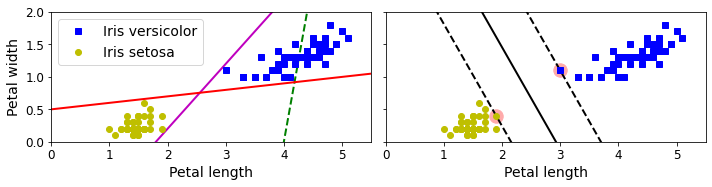

In [8]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

그림 저장: sensitivity_to_feature_scales_plot


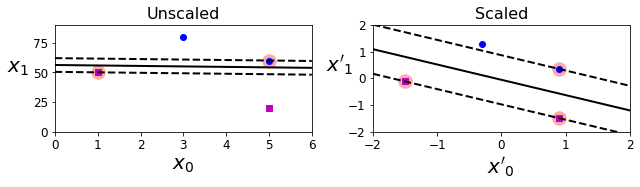

In [9]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

그림 저장: sensitivity_to_outliers_plot


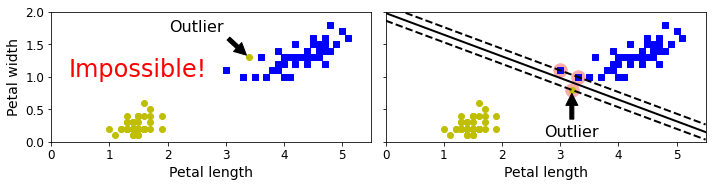

In [10]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

In [11]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [12]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [13]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [14]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


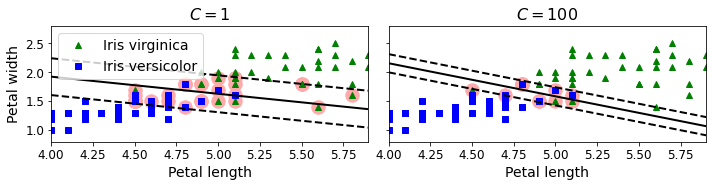

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

그림 저장: higher_dimensions_plot


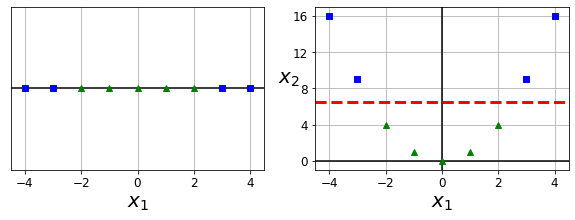

In [16]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust()

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

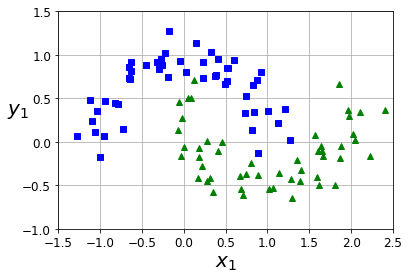

In [17]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$y_1$", fontsize=20, rotation=0)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [18]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

그림 저장: moons_polynomial_svc_plot


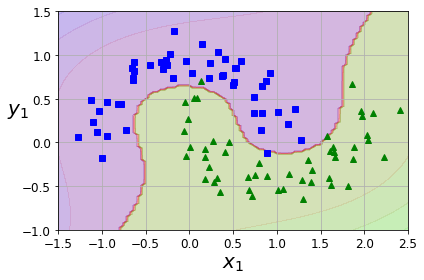

In [19]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

In [20]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [21]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


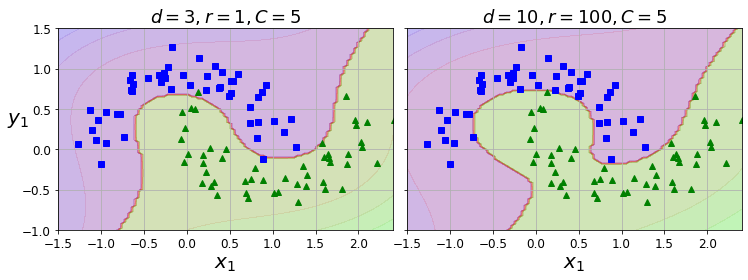

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

그림 저장: kernel_method_plot


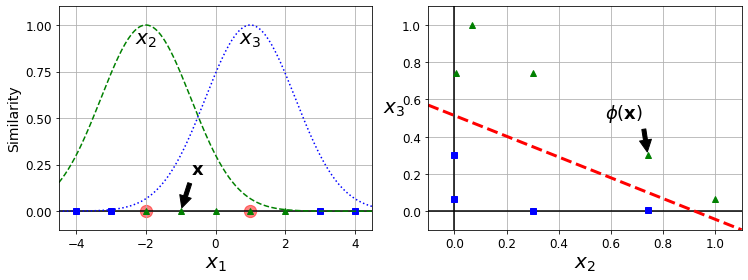

In [23]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [24]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [25]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

그림 저장: moons_rbf_svc_plot


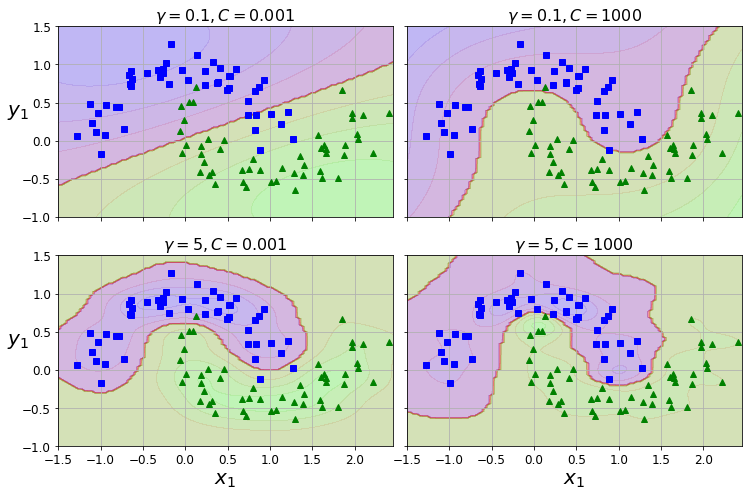

In [26]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

In [27]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m ,1)).ravel()

In [28]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [29]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


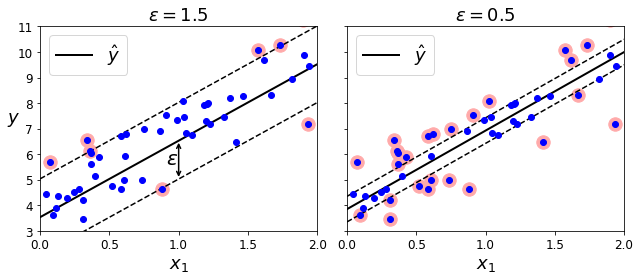

In [30]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [31]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [32]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [33]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

그림 저장: svm_with_polynomial_kernel_plot


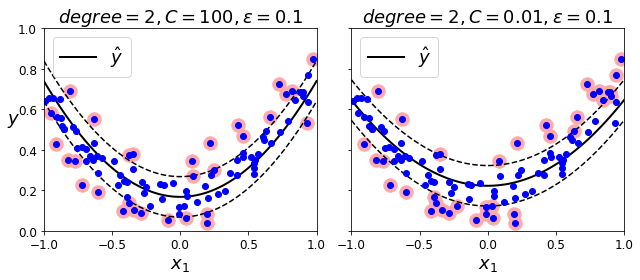

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

In [35]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)    # Iris verginica

그림 저장: iris_3D_plot


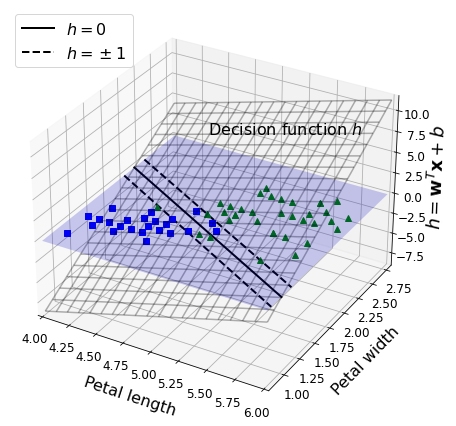

In [55]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

그림 저장: small_w_large_margin_plot


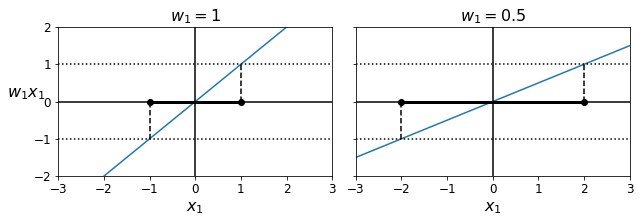

In [72]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

# 미주

<b id="p01">1</b> 왼쪽 그래프의 결정 경계는 설명을 위해 임의의 직선을 그은 것이다.[↩](#a01)

<b id="p02">2</b> 여기서는 편의상 <i>w</i><sub>0</sub>를 따로 표기했다. 이 식은 <i>w</i><sub>2</sub>축과 만나는 절편을 1 / <i>w</i><sub>2</sub> 만큼 위아래로 결정 경계와 나란하게 이동한 직선이 된다. [↩](#a02)

<b id="p03">3</b> 직선 Ax+By+c=0과 점(x<sub>0</sub>, y<sub>0</sub>) 사이의 거리 <i>d</i>=(Ax<sub>0</sub>+By<sub>0</sub>+c)/(√(A<sup>2</sup>+B<sup>2</sup>) 이므로 왼쪽 식은 두 서포트 벡터 x<sub>pos</sub>와 x<sub>neg</sub> 사이의 거리가 된다. [↩](#a03)

<b id="p04">4</b> 전칭 기호 ∀<sub><i>i</i></sub>는 '모든 샘플에 대해서'라는 뜻이다. [↩](#a04)

<b id="p05">5</b> [그림 4]의 왼쪽과 오른쪽 그래프에 있는 이상치는 설명을 위해 임의로 추가한 것이다. [↩](#a05)

<b id="p06">6</b> 사이킷런의 LinearSVC는 <code>predict_proba()</code> 메서드를 제공하지 않지만, SVC 모델은 probability=True로 매개변수를 지정하면 <code>predict_proba()</code> 메서드를 제공한다. SVC의 probability 매개변수 기본값은 False다.[↩](#a06)

<b id="p07">7</b> 이 식에서 n은 샘플 수다. 확률적 경사 하강법은 샘플 하나씩 그레디언트를 계산하여 모델 파라미터를 갱신하기 때문에 훈련 세트 수에 반비례해야 비슷한 규제를 적용할 수 있다. [↩](#a07)

<b id="p08">8</b> 이 내용은 <code>SVC(kernel="linear")</code>에 상응하는 LinearSVC의 설정을 설명하는 것이다. LinearSVC는 보통의 SVM 구현과 달리 규제에 편향을 포함하고 있어서 데이터의 스케일을 맞추지 않고 SVC 모델과 비교하면 큰 차이가 난다. LinearSVC의 loss 매개변수의 기본값은 "squared_hinge"이다. [그림 6]의 그래프는 StandardScaler로 데이터 스케일을 변경하고 LinearSVC로 결정 경계를 찾은 후 원본 좌표 공간으로 가중치와 편향의 스케일을 복원하여 나타낸 것이다. [↩](#a08)

<b id="p09">9</b> LogisticRegression의 solver 매개변수의 기본값이 LIBLINEAR 라이브러리를 사용하는 'liblinear'이다. 이외에도 'lbfgs', 'sag' 등을 사용할 수 있다. 사이킷런 0.19 버전부터는 'liblinear'와 마찬가지로 L1, L2 규제가 가능하고 대규모 데이터에 적합한 'saga' 옵션이 추가되었다. [↩](#a09)

<b id="p10">10</b> 사이킷런에서는 선형 SVM모델을 위해 LIBLINEAR 라이브러리를 사용하는 분류를 위한 LinearSVC와 회귀를 위한 LinearSVR 클래스를 제공한다. 선형 SVM 문제에서는 'linear' 커널을 사용하는 SVC, SVR보다 빠르다. [↩](#a10)

<b id="p11">11</b> moons 데이터셋은 사이킷런의 <code>make_moons()</code> 함수를 사용해서 만든 두 개의 반달 모양 데이터셋이다. [↩](#a11)

<b id="p12">12</b> coef0 매개변수는 다항식 커널에 있는 상수항 r이다. 다항식 커널은 차수가 높아질수록 1보다 작은 값과 1보다 큰 값의 차이가 크게 벌어지므로 coef0을 적절한 값으로 지정하면 고차항의 영향을 줄일 수 있다. 기본값은 0이다. [↩](#a12)

<b id="p13">13</b> 가우시안 커널을 사용하여 계산된 값은 지수 함수의 테일러 급수 전개를 생각하면 무한 차원의 다항식을 사용하여 만든 것으로 생각할 수 있다. 커널 방법은 이렇게 고차원 표현을 실제 만들지 않고 커널 함수의 계산 결과만 사용한다. 고차원 표현을 명시적으로 만들지 않기 때문에 이 공간에 대한 결정 경계도 찾을 수 없다. 커널 방법을 사용할 때는 SVM의 목적 함수에 커널 함수를 적용하여 w와 b를 소거한다. 이렇게 바뀐 목적 함수를 쌍대 형식<sup>dual form</sup>이라고 부른다. 예측은 새로운 데이터와 서포트 벡터에 커널 함수를 적용하여 계산한다. SVC 클래스의 kernel 매개변수가 'linear'가 아닌 경우 항상 쌍대 문제가 되며 가중치 파라미터 coef_ 속성은 정의되지 않는다. LinearSVC 클래스는 dual 매개변수의 기본값 True를 False로 바꾸어 쌍대 문제가 아니라 원 문제<sup>primal problem</sup>를 풀 수도 있다. [↩](#a13)

<b id="p14">14</b> 가우시안 RBF의 식에서 $\gamma$는 0보다 커야 하며 값이 작을수록 폭이 넓은 종 모양이 된다. [↩](#a14)

<b id="p15">15</b> [그림 10]의 왼쪽 그래프에서 사각형으로 표시된 샘플은 두 개의 랜드마크 중 적오도 하나와 멀리 떨어져 있으므로 오른쪽 그래프에서 새로 만들어진 특성에서 이 샘플들은 0에 아주 가깝게 나타나 있다. [↩](#a15)

<b id="p16">16</b> SVM 모델에 규제를 가할 때는 gamma와 C 하이퍼파라미터를 동시에 조정하는 것이 좋다. [↩](#a16)

<b id="p17">17</b> 문자열 커널은 두 문자열의 유사도를 비교하는 함수로 생각할 수 있다. 서브시퀀스는 연속되지 않더라도 순서대로 나열되는 모든 경우를 고려하여 거리를 측정한다. 즉, "ac"는 "abc"의 서브시퀀스다. 로디<sup>Lodhi</sup> 등이 쓴 「Text Classification using String Kernels」(<a href='https://www.jmlr.org/papers/volume2/lodhi02a/lodhi02a.pdf' target='blank'>https://www.jmlr.org/papers/volume2/lodhi02a/lodhi02a.pdf</a>)에 소개되었다. 레벤슈타인 거리는 한 문자열이 다른 문자열과 같아지기 위해 필요한 추가, 삭제, 수정의 횟수다. 이 기법을 연구한 러시아 과학자 블라디미르 레벤슈타인<sup>Vladimir Levenshtein</sup>의 이름에서 따왔다. 사이킷런에서는 문자열 커널을 지원하지 않지만 직접 커널 함수를 만들어 SVC의 kernel 매개변수에 함수 객체를 인수로 전달할 수 있다. [↩](#a17)

<b id="p18">18</b> Chih-Jen Lin et al., "A Dual Coordinate Descent Method for Large-Scale Linear SVM," Proceedings of the 25th International Conference on Machine Learning (2008): 408-415. <a href='https://www.csie.ntu.edu.tw/~cjlin/papers/cddual.pdf' target='blank'>https://www.csie.ntu.edu.tw/~cjlin/papers/cddual.pdf</a> [↩](#a18)

<b id="p19">19</b> SVC의 tol 매개변수 기본값은 0.001이고 LinearSVC의 tol 매개변수 기본값은 0.0001이다. [↩](#a19)

<b id="p20">20</b> John Platt, "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" (Microsoft Research technical report, April 21, 1998), <a href='https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf' target='blank'>https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf</a> [↩](#a20)

<b id="p21">21</b> liblinear와 libsvm은 국립 타이완 대학교 컴퓨터 과학부의 린 지첸<sup>Lin Chih-Jen</sup> 교수 팀에서 개발했으며 가장 널리 사용되는 SVM 라이브러리 중 하나다. [↩](#a21)

<b id="p22">22</b> 허용오차를 설명할 때 나온 하이퍼파라미터 $\varepsilon$과 혼동하지 말자. SVM 회귀 모델인 SVR과 LinearSVR에서 허용오차 tol 매개변수, 도로의 폭은 epsilon 매개변수로 지정한다. SVR과 LinearSVR의 tol 매개변수의 기본값은 SVC, LinearSVC와 마찬가지로 각각 0.001, 0.0001이다. [↩](#a22)

<b id="p23">23</b> 조금 더 일반저그로 말하면 m개의 특성이 있을 때 결정 함수는 m차원의 <b>초평면</b><sup>hyperplane</sup>이고 결정 경계는 (m-1)차원의 초평면이다. [↩](#a23)

<b id="p24">24</b> $||\textbf{w}||_2$는 $l_2$ 노름을 말한다. $l_2$ 노름의 미분은 원점에서 분모가 0이 되므로 도함수가 정의되지 않는다. [↩](#a24)

<b id="p25">25</b> 목적 함수가 볼록 함수이고, 부등식 제약 조건이 연속 미분 가능하면서 볼록 함수다. [↩](#a25)

<b id="p26">26</b> LinearSVC, LinearSVR의 매개변수 dual의 기본값 True를 False로 바꾸면 원 문제를 선택한다. SVC, SVR은 쌍대 문제만을 푼다. [↩](#a26)
